In [11]:
import os
import time
import uuid
import cv2

In [22]:
IMAGES_PATH = os.path.join('data','images')
number_images = 30

In [31]:
cap = cv2.VideoCapture(0)
time.sleep(2)
for imgnum in range(number_images):
    print('Collecting image {}'.format(imgnum))
    ret, frame = cap.read()
    imgname = os.path.join(IMAGES_PATH,f'{str(uuid.uuid1())}.jpg')
    cv2.imwrite(imgname, frame)
    cv2.imshow('frame', frame)
    time.sleep(0.5)

    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()

In [23]:
!labelme

2024-12-21 01:03:46,607 [INFO   ] __init__:get_config:67- Loading config file from: C:\Users\ASIS VIVOBOOJK\.labelmerc


In [13]:
import tensorflow as tf
import json
import numpy as np
from matplotlib import pyplot as plt

In [14]:
gpus=tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu,True)

In [15]:
tf.config.list_physical_devices('GPU')

[]

In [28]:
images=tf.data.Dataset.list_files('data\\images\\*.jpg')

InvalidArgumentError: Expected 'tf.Tensor(False, shape=(), dtype=bool)' to be true. Summarized data: b'No files matched pattern: data\\images\\*.jpg'

In [9]:
images.as_numpy_iterator().next()

NameError: name 'images' is not defined

In [24]:
def load_image(x): 
    byte_img = tf.io.read_file(x)
    img = tf.io.decode_jpeg(byte_img)
    return img

In [25]:
images =  images.map(load_image)

NameError: name 'images' is not defined

In [26]:
images.as_numpy_iterator().next()

NameError: name 'images' is not defined

In [27]:
type(images)

NameError: name 'images' is not defined

In [61]:
image_generator = images.batch(4).as_numpy_iterator()

In [71]:
plot_images = image_generator.next()

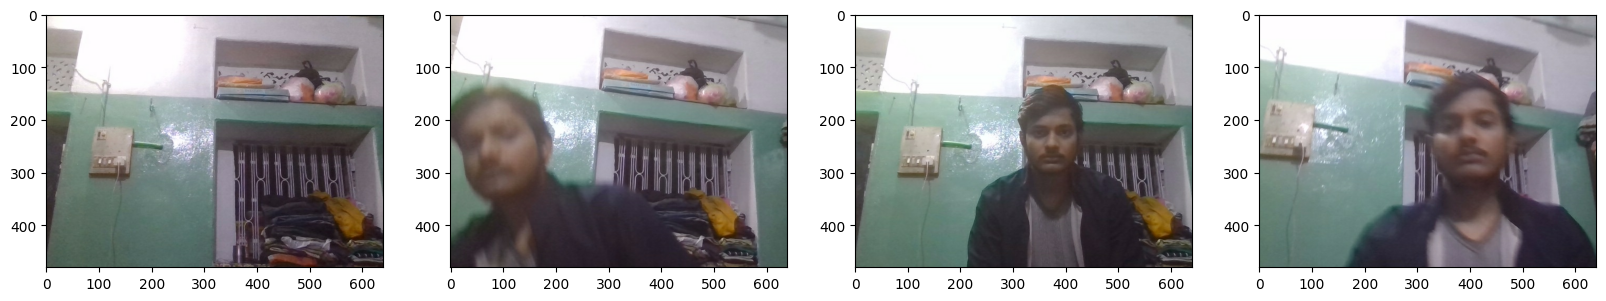

In [72]:
fig , ax =plt.subplots(ncols=4, figsize=(20,20))
for idx, image in enumerate(plot_images):
    ax[idx].imshow(image)
plt.show()

parition unaugmented data

In [73]:
for folder in ['train','test','val']:
    for file in os.listdir(os.path.join('data', folder, 'images')):
        
        filename = file.split('.')[0]+'.json'
        existing_filepath = os.path.join('data','labels', filename)
        if os.path.exists(existing_filepath): 
            new_filepath = os.path.join('data',folder,'labels',filename)
            os.replace(existing_filepath, new_filepath)     

In [74]:
import albumentations as alb

In [76]:
augmentor = alb.Compose([alb.RandomCrop(width=450, height=450), 
                         alb.HorizontalFlip(p=0.5), 
                         alb.RandomBrightnessContrast(p=0.2),
                         alb.RandomGamma(p=0.2), 
                         alb.RGBShift(p=0.2), 
                         alb.VerticalFlip(p=0.5)], 
                       bbox_params=alb.BboxParams(format='albumentations', 
                                                  label_fields=['class_labels']))

In [77]:
img =cv2.imread(os.path.join('data','train', 'images', 'ddaede49-bdf6-11ef-aa77-4c445b35880a.jpg'))

In [78]:
img

array([[[252, 254, 254],
        [252, 254, 254],
        [252, 254, 254],
        ...,
        [183, 179, 178],
        [184, 180, 179],
        [185, 181, 180]],

       [[252, 254, 254],
        [252, 254, 254],
        [252, 254, 254],
        ...,
        [184, 180, 179],
        [185, 181, 180],
        [185, 181, 180]],

       [[252, 254, 254],
        [252, 254, 254],
        [252, 254, 254],
        ...,
        [184, 181, 177],
        [184, 181, 177],
        [184, 181, 177]],

       ...,

       [[121, 136, 108],
        [121, 136, 108],
        [121, 136, 108],
        ...,
        [106, 112,  89],
        [105, 111,  88],
        [104, 110,  87]],

       [[121, 136, 108],
        [121, 136, 108],
        [122, 137, 109],
        ...,
        [106, 112,  89],
        [104, 110,  87],
        [103, 109,  86]],

       [[119, 134, 106],
        [120, 135, 107],
        [121, 136, 108],
        ...,
        [105, 111,  88],
        [102, 108,  85],
        [100, 106,  83]]

In [79]:
with open(os.path.join('data','train','labels','ddaede49-bdf6-11ef-aa77-4c445b35880a.json'), 'r' ) as f:
    label= json.load(f)

In [82]:
label['shapes'][0]['points']

[[288.4210526315789, 147.23684210526318],
 [463.4210526315789, 391.9736842105263]]

In [83]:
coords=[0,0,0,0]
coords[0]=label['shapes'][0]['points'][0][0]
coords[1]=label['shapes'][0]['points'][0][1]
coords[2]=label['shapes'][0]['points'][1][0]
coords[3]=label['shapes'][0]['points'][1][1]

In [84]:
coords

[288.4210526315789, 147.23684210526318, 463.4210526315789, 391.9736842105263]

In [85]:
coords=list(np.divide(coords,[640,480,640,480]))

In [86]:
coords

[np.float64(0.45065789473684204),
 np.float64(0.30674342105263164),
 np.float64(0.724095394736842),
 np.float64(0.8166118421052632)]

In [87]:
augmented = augmentor(image=img, bboxes=[coords],class_labels=['face'])

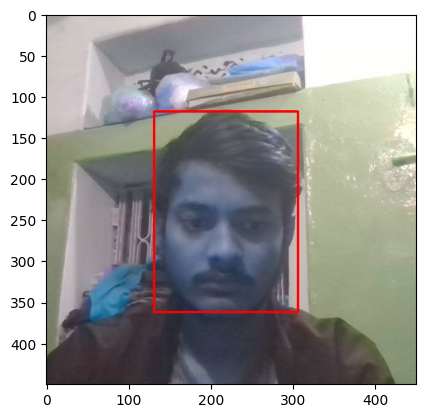

In [91]:
cv2.rectangle(augmented['image'], 
              tuple(np.multiply(augmented['bboxes'][0][:2], [450,450]).astype(int)),
              tuple(np.multiply(augmented['bboxes'][0][2:], [450,450]).astype(int)), 
                    (255,0,0), 2)

plt.imshow(augmented['image'])

In [94]:
for partition in ['train','test','val']: 
    for image in os.listdir(os.path.join('data', partition, 'images')):
        img = cv2.imread(os.path.join('data', partition, 'images', image))

        coords = [0,0,0.00001,0.00001]
        label_path = os.path.join('data', partition, 'labels', f'{image.split(".")[0]}.json')
        if os.path.exists(label_path):
            with open(label_path, 'r') as f:
                label = json.load(f)

            coords[0] = label['shapes'][0]['points'][0][0]
            coords[1] = label['shapes'][0]['points'][0][1]
            coords[2] = label['shapes'][0]['points'][1][0]
            coords[3] = label['shapes'][0]['points'][1][1]
            coords = list(np.divide(coords, [640,480,640,480]))

        try: 
            for x in range(60):
                augmented = augmentor(image=img, bboxes=[coords], class_labels=['face'])
                cv2.imwrite(os.path.join('aug_data', partition, 'images', f'{image.split(".")[0]}.{x}.jpg'), augmented['image'])

                annotation = {}
                annotation['image'] = image

                if os.path.exists(label_path):
                    if len(augmented['bboxes']) == 0: 
                        annotation['bbox'] = [0,0,0,0]
                        annotation['class'] = 0 
                    else: 
                        annotation['bbox'] = augmented['bboxes'][0]
                        annotation['class'] = 1
                else: 
                    annotation['bbox'] = [0,0,0,0]
                    annotation['class'] = 0 


                with open(os.path.join('aug_data', partition, 'labels', f'{image.split(".")[0]}.{x}.json'), 'w') as f:
                    json.dump(annotation, f)

        except Exception as e:
            print(e)

C:\Users\ASIS VIVOBOOJK\AppData\Local\Programs\Python\Python311\Lib\site-packages\albumentations\core\bbox_utils.py:478: RuntimeWarning: invalid value encountered in divide
  & (clipped_box_areas / denormalized_box_areas >= min_visibility - epsilon)


In [29]:
train_images = tf.data.Dataset.list_files('aug_data\\train\\images\\*.jpg', shuffle=False)
train_images = train_images.map(load_image)
train_images = train_images.map(lambda x: tf.image.resize(x, (120,120)))
train_images = train_images.map(lambda x: x/255)

In [30]:
test_images = tf.data.Dataset.list_files('aug_data\\test\\images\\*.jpg', shuffle=False)
test_images = test_images.map(load_image)
test_images = test_images.map(lambda x: tf.image.resize(x, (120,120)))
test_images = test_images.map(lambda x: x/255)

In [31]:
val_images = tf.data.Dataset.list_files('aug_data\\val\\images\\*.jpg', shuffle=False)
val_images = val_images.map(load_image)
val_images = val_images.map(lambda x: tf.image.resize(x, (120,120)))
val_images = val_images.map(lambda x: x/255)

In [32]:
train_images.as_numpy_iterator().next()

array([[[0.4862745 , 0.4862745 , 0.53333336],
        [0.48480392, 0.48480392, 0.5240196 ],
        [0.48235294, 0.48235294, 0.52156866],
        ...,
        [0.7019608 , 0.70980394, 0.7058824 ],
        [0.7019608 , 0.70980394, 0.7058824 ],
        [0.7019608 , 0.70980394, 0.7058824 ]],

       [[0.4862745 , 0.4862745 , 0.53333336],
        [0.48621324, 0.48621324, 0.5262868 ],
        [0.4862745 , 0.4862745 , 0.5254902 ],
        ...,
        [0.7019608 , 0.70980394, 0.7058824 ],
        [0.7019608 , 0.70980394, 0.7058824 ],
        [0.7019608 , 0.70980394, 0.7058824 ]],

       [[0.48645833, 0.48645833, 0.5335172 ],
        [0.48278186, 0.48278186, 0.5298407 ],
        [0.48578432, 0.48578432, 0.5328431 ],
        ...,
        [0.7019608 , 0.70980394, 0.7058824 ],
        [0.7019608 , 0.70980394, 0.7058824 ],
        [0.7019608 , 0.70980394, 0.7058824 ]],

       ...,

       [[0.20931372, 0.18970588, 0.21715686],
        [0.20520833, 0.19344363, 0.2208946 ],
        [0.20680147, 0

In [33]:
def load_labels(label_path):
    with open(label_path.numpy() , 'r' , encoding="utf-8") as f:
        label=json.load(f)
    return [label['class']],label['bbox']

In [34]:
train_labels = tf.data.Dataset.list_files('aug_data\\train\\labels\\*.json', shuffle=False)
train_labels = train_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))


In [35]:
test_labels = tf.data.Dataset.list_files('aug_data\\test\\labels\\*.json', shuffle=False)
test_labels = test_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

In [36]:
val_labels = tf.data.Dataset.list_files('aug_data\\val\\labels\\*.json', shuffle=False)
val_labels = val_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

In [37]:
train_labels.as_numpy_iterator().next()

(array([1], dtype=uint8),
 array([0.5254, 0.4634, 0.9   , 0.9106], dtype=float16))

In [38]:
len(train_images), len(train_labels), len(test_images), len(test_labels), len(val_images), len(val_labels)

(3780, 3780, 780, 780, 840, 840)

In [39]:
train = tf.data.Dataset.zip((train_images, train_labels))
train=train.shuffle(5000)
train=train.batch(8)
train=train.prefetch(4)

In [40]:
test = tf.data.Dataset.zip((test_images, test_labels))
test = test.shuffle(5000)
test = test.batch(8)
test = test.prefetch(4)

In [41]:
val = tf.data.Dataset.zip((val_images, val_labels))
val=val.shuffle(5000)
val=val.batch(8)
val=val.prefetch(4)

In [46]:
train.as_numpy_iterator().next()[1]

(array([[0],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1]], dtype=uint8),
 array([[0.     , 0.     , 0.     , 0.     ],
        [0.833  , 0.136  , 1.     , 0.8496 ],
        [0.9263 , 0.4478 , 1.     , 0.793  ],
        [0.2268 , 0.2234 , 0.651  , 0.861  ],
        [0.     , 0.09375, 0.3643 , 0.804  ],
        [0.3357 , 0.2866 , 0.6343 , 0.6787 ],
        [0.387  , 0.2112 , 0.7085 , 0.656  ],
        [0.6255 , 0.     , 0.8823 , 0.1978 ]], dtype=float16))

In [47]:
data_samples = train.as_numpy_iterator()

In [48]:
res = data_samples.next()

In [43]:
import matplotlib.pyplot as plt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].


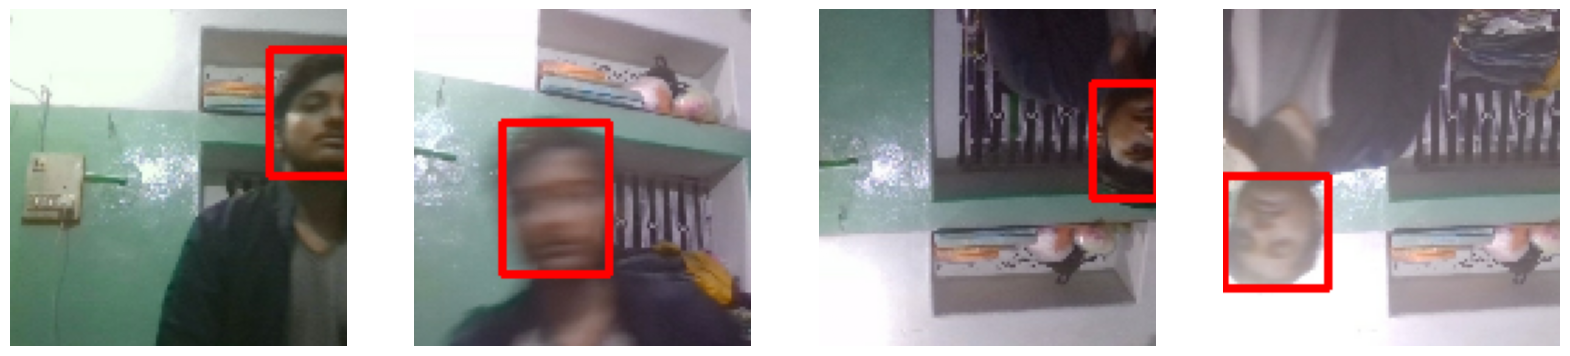

In [50]:
fig, ax = plt.subplots(ncols=4, figsize=(20, 20))

for idx in range(4): 
    sample_image = res[0][idx].copy()  # Make a writable copy
    sample_coords = res[1][1][idx]
    
    # Draw a rectangle on the image
    cv2.rectangle(sample_image, 
                  tuple(np.multiply(sample_coords[:2], [120, 120]).astype(int)),
                  tuple(np.multiply(sample_coords[2:], [120, 120]).astype(int)), 
                  (255, 0, 0), 2)

    # Display the image with the rectangle
    ax[idx].imshow(sample_image)
    ax[idx].axis('off')  # Hide axis for better visualization


In [53]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input , Conv2D , Dense,GlobalMaxPooling2D
from tensorflow.keras.applications import VGG16

In [54]:
vgg= VGG16(include_top = False)

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 12s 0us/step


In [55]:
vgg.summary()

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, None, None, 3)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, None, None, 64)      │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, None, None, 64)      │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, None, None, 64)      │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, None, None, 128)     │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, None, None, 128)     │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, None, None, 128)     │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, None, None, 256)     │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, None, None, 256)     │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, None, None, 256)     │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, None, None, 256)     │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, None, None, 512)     │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, None, None, 512)     │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, None, None, 512)     │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, None, None, 512)     │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, None, None, 512)     │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, None, None, 512)     │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, None, None, 512)     │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, None, None, 512)     │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 14,714,688 (56.13 MB)

 Non-trainable params: 0 (0.00 B)

In [64]:
def build_model():

    input_layer=Input(shape=(120,120,3))
    vgg = VGG16(include_top=False)(input_layer)

    f1=GlobalMaxPooling2D()(vgg)
    class1= Dense(2048, activation='relu')(f1)
    class2 = Dense(1, activation='sigmoid')(class1)

    f2=GlobalMaxPooling2D()(vgg)
    regress1= Dense(2048, activation='relu')(f2)
    regress2 = Dense(4, activation='sigmoid')(regress1)

    facetracker = Model(inputs= input_layer , outputs=[class2, regress2])
    return facetracker

    

In [59]:
train.as_numpy_iterator().next()[1]

(array([[0],
        [1],
        [1],
        [1],
        [0],
        [1],
        [1],
        [1]], dtype=uint8),
 array([[0.     , 0.     , 0.     , 0.     ],
        [0.     , 0.     , 0.1057 , 0.3784 ],
        [0.05975, 0.04837, 0.659  , 0.92   ],
        [0.4192 , 0.251  , 0.811  , 0.713  ],
        [0.     , 0.     , 0.     , 0.     ],
        [0.147  , 0.2267 , 0.5474 , 0.7734 ],
        [0.714  , 0.2993 , 1.     , 0.7817 ],
        [0.     , 0.4324 , 0.1389 , 0.83   ]], dtype=float16))

In [65]:
facetracker = build_model()

In [66]:
facetracker.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)    │ (None, 120, 120, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ vgg16 (Functional)            │ (None, 3, 3, 512)         │      14,714,688 │ input_layer_5[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ global_max_pooling2d_4        │ (None, 512)               │               0 │ vgg16[0][0]                │
│ (GlobalMaxPooling2D)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ global_max_pooling2d_5        │ (None, 512)               │               0 │ vgg16[0][0]                │
│ (GlobalMaxPooling2D)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_8 (Dense)               │ (None, 2048)              │       1,050,624 │ global_max_pooling2d_4[0]… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_10 (Dense)              │ (None, 2048)              │       1,050,624 │ global_max_pooling2d_5[0]… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_9 (Dense)               │ (None, 1)                 │           2,049 │ dense_8[0][0]              │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_11 (Dense)              │ (None, 4)                 │           8,196 │ dense_10[0][0]             │
└───────────────────────────────┴───────────────────────────┴─────────────────┴────────────────────────────┘

 Total params: 16,826,181 (64.19 MB)

 Trainable params: 16,826,181 (64.19 MB)

 Non-trainable params: 0 (0.00 B)

In [104]:
X, y = train.as_numpy_iterator().next()

In [105]:
X.shape

(8, 120, 120, 3)

In [106]:
classes, coords = facetracker.predict(X)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 263ms/step


In [107]:
classes, coords

(array([[0.5241748 ],
        [0.5467203 ],
        [0.54095536],
        [0.51012176],
        [0.5384424 ],
        [0.49396324],
        [0.57923245],
        [0.6038693 ]], dtype=float32),
 array([[0.22975215, 0.40707475, 0.62176275, 0.52021855],
        [0.32160184, 0.36028245, 0.49925023, 0.57645744],
        [0.38797763, 0.4245471 , 0.5722672 , 0.6146896 ],
        [0.2888594 , 0.44683757, 0.52942896, 0.4944828 ],
        [0.2768758 , 0.38524514, 0.55291486, 0.6255726 ],
        [0.33758062, 0.3580488 , 0.58068794, 0.62616396],
        [0.3708174 , 0.32460138, 0.5417932 , 0.7106475 ],
        [0.3538264 , 0.34595692, 0.64969444, 0.6958425 ]], dtype=float32))

In [108]:
len(train)

473

In [109]:
batches_per_epoch = len(train)
lr_decay = (1./0.75 -1)/batches_per_epoch

In [110]:
opt = tf.keras.optimizers.Adam(learning_rate=0.0001, decay=lr_decay)

In [111]:
def localization_loss(y_true, yhat):            
    delta_coord = tf.reduce_sum(tf.square(y_true[:,:2] - yhat[:,:2]))
                  
    h_true = y_true[:,3] - y_true[:,1] 
    w_true = y_true[:,2] - y_true[:,0] 

    h_pred = yhat[:,3] - yhat[:,1] 
    w_pred = yhat[:,2] - yhat[:,0] 
    
    delta_size = tf.reduce_sum(tf.square(w_true - w_pred) + tf.square(h_true-h_pred))
    
    return delta_coord + delta_size

In [112]:
classloss = tf.keras.losses.BinaryCrossentropy()
regressloss = localization_loss

In [113]:
localization_loss(y[1], coords)

<tf.Tensor: shape=(), dtype=float32, numpy=1.322076678276062>

In [114]:
classloss(y[0], classes)

<tf.Tensor: shape=(), dtype=float32, numpy=0.614011287689209>

In [115]:
regressloss(y[1], coords)

<tf.Tensor: shape=(), dtype=float32, numpy=1.322076678276062>

In [153]:
class FaceTracker(Model): 
    def __init__(self, eyetracker, **kwargs): 
        super().__init__(**kwargs)
        self.model = eyetracker

    def compile(self, opt, classloss, localizationloss, **kwargs):
        super().compile(**kwargs)
        self.closs = classloss
        self.lloss = localizationloss
        self.opt = opt
    
   
    def train_step(self, batch, **kwargs): 
        X, y = batch
        
        # Ensure shapes are explicitly defined for y[0] and y[1]
        y0 = tf.ensure_shape(y[0], [None, self.model.output_shape[0][1]])  # Classes shape
        y1 = tf.ensure_shape(y[1], [None, self.model.output_shape[1][1]])  # Coordinates shape
        
        with tf.GradientTape() as tape: 
            classes, coords = self.model(X, training=True)
            
            batch_classloss = self.closs(y0, classes)
            batch_localizationloss = self.lloss(tf.cast(y1, tf.float32), coords)
            
            total_loss = batch_localizationloss + 0.5 * batch_classloss
            
            grad = tape.gradient(total_loss, self.model.trainable_variables)
        opt.apply_gradients(zip(grad, self.model.trainable_variables))
        
        return {
            "total_loss": total_loss, 
            "class_loss": batch_classloss, 
            "regress_loss": batch_localizationloss
        }

    def test_step(self, batch, **kwargs): 
        X, y = batch
        
        # Ensure shapes are explicitly defined for y[0] and y[1]
        y0 = tf.ensure_shape(y[0], [None, self.model.output_shape[0][1]])  # Classes shape
        y1 = tf.ensure_shape(y[1], [None, self.model.output_shape[1][1]])  # Coordinates shape
        
        classes, coords = self.model(X, training=False)
        
        batch_classloss = self.closs(y0, classes)
        batch_localizationloss = self.lloss(tf.cast(y1, tf.float32), coords)
        total_loss = batch_localizationloss + 0.5 * batch_classloss
        
        return {
            "total_loss": total_loss, 
            "class_loss": batch_classloss, 
            "regress_loss": batch_localizationloss
    }
        
    def call(self, X, **kwargs): 
        return self.model(X, **kwargs)


In [154]:
model = FaceTracker(facetracker)

In [155]:
model.compile(opt, classloss, regressloss)

In [156]:
logdir = 'logs'

In [157]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [158]:
hist = model.fit(train, epochs=10, validation_data=val, callbacks=[tensorboard_callback])

Epoch 1/10
473/473 ━━━━━━━━━━━━━━━━━━━━ 348s 727ms/step - class_loss: 0.0680 - regress_loss: 0.1799 - total_loss: 0.2139 - val_class_loss: 0.4366 - val_regress_loss: 0.2096 - val_total_loss: 0.4279
Epoch 2/10
473/473 ━━━━━━━━━━━━━━━━━━━━ 375s 788ms/step - class_loss: 0.0514 - regress_loss: 0.1146 - total_loss: 0.1403 - val_class_loss: 0.0203 - val_regress_loss: 0.0402 - val_total_loss: 0.0503
Epoch 3/10
473/473 ━━━━━━━━━━━━━━━━━━━━ 405s 851ms/step - class_loss: 0.0472 - regress_loss: 0.0945 - total_loss: 0.1181 - val_class_loss: 0.0074 - val_regress_loss: 0.0553 - val_total_loss: 0.0590
Epoch 4/10
473/473 ━━━━━━━━━━━━━━━━━━━━ 399s 837ms/step - class_loss: 0.0386 - regress_loss: 0.0905 - total_loss: 0.1098 - val_class_loss: 0.0159 - val_regress_loss: 0.0303 - val_total_loss: 0.0382
Epoch 5/10
473/473 ━━━━━━━━━━━━━━━━━━━━ 362s 759ms/step - class_loss: 0.0459 - regress_loss: 0.1192 - total_loss: 0.1421 - val_class_loss: 0.0033 - val_regress_loss: 0.0940 - val_total_loss: 0.0957
Epoch 6/10

In [159]:
hist.history

{'class_loss': [0.015149206854403019,
  0.013008222915232182,
  0.0005398066132329404,
  0.014748680405318737,
  0.09003257751464844,
  0.0038449617568403482,
  0.005228975787758827,
  0.00047083976096473634,
  9.250375296687707e-05,
  2.4773623863438843e-06],
 'regress_loss': [0.03905995190143585,
  0.030837228521704674,
  0.009077178314328194,
  0.0358152911067009,
  0.07451265305280685,
  0.02208796516060829,
  0.008359475061297417,
  0.0031464260537177324,
  0.01724204607307911,
  0.030635200440883636],
 'total_loss': [0.046634554862976074,
  0.037341341376304626,
  0.009347081184387207,
  0.043189629912376404,
  0.11952894181013107,
  0.024010445922613144,
  0.01097396295517683,
  0.0033818460069596767,
  0.017288297414779663,
  0.030636439099907875],
 'val_class_loss': [0.4365878403186798,
  0.020268406718969345,
  0.0073518529534339905,
  0.015895750373601913,
  0.0032540527172386646,
  1.3967952728271484,
  0.011853598989546299,
  1.4150362014770508,
  0.004116118885576725,
  0

The plots aren't perfect, we can see some spikes, but that's okay as the final output is fine.

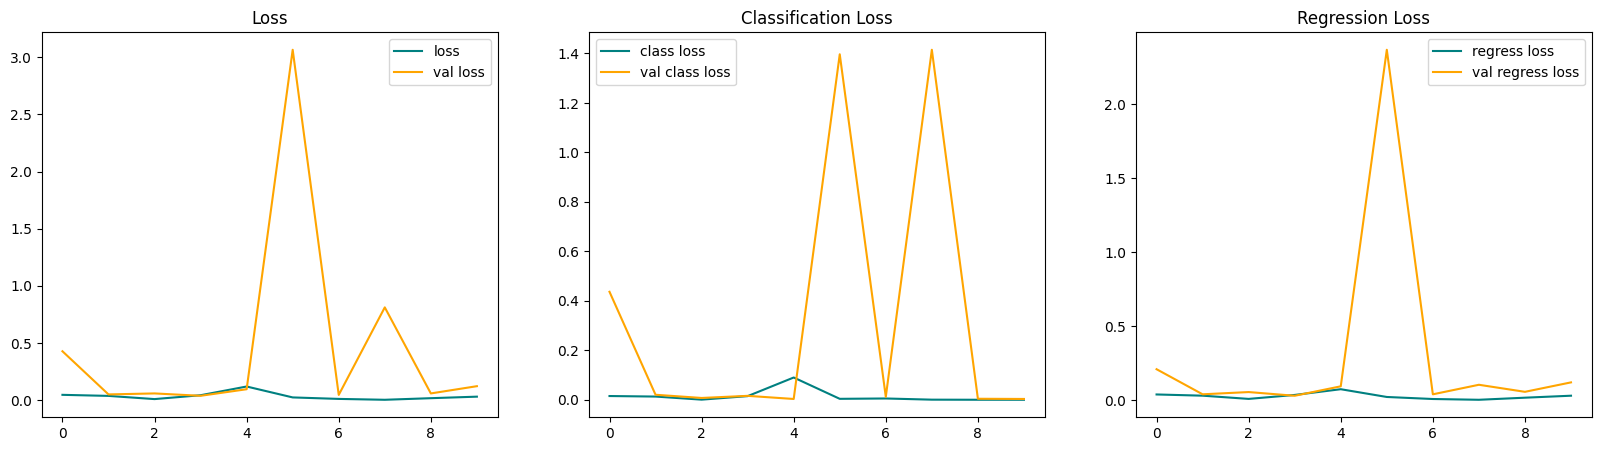

In [160]:
fig, ax = plt.subplots(ncols=3, figsize=(20,5))

ax[0].plot(hist.history['total_loss'], color='teal', label='loss')
ax[0].plot(hist.history['val_total_loss'], color='orange', label='val loss')
ax[0].title.set_text('Loss')
ax[0].legend()

ax[1].plot(hist.history['class_loss'], color='teal', label='class loss')
ax[1].plot(hist.history['val_class_loss'], color='orange', label='val class loss')
ax[1].title.set_text('Classification Loss')
ax[1].legend()

ax[2].plot(hist.history['regress_loss'], color='teal', label='regress loss')
ax[2].plot(hist.history['val_regress_loss'], color='orange', label='val regress loss')
ax[2].title.set_text('Regression Loss')
ax[2].legend()

plt.show()

In [161]:
test_data = test.as_numpy_iterator()

In [171]:
test_sample = test_data.next()

In [172]:
yhat = facetracker.predict(test_sample[0])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 473ms/step


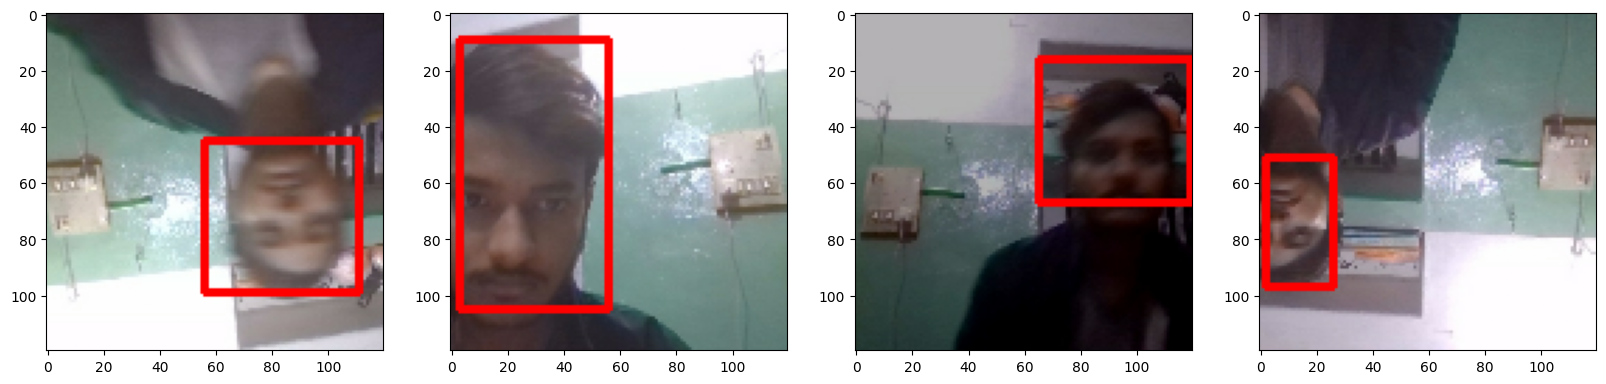

In [173]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx in range(4):
    sample_image = test_sample[0][idx].copy()  # Make a copy of the image
    sample_coords = yhat[1][idx]
    
    if yhat[0][idx] > 0.9:
        cv2.rectangle(sample_image,
                      tuple(np.multiply(sample_coords[:2], [120,120]).astype(int)),
                      tuple(np.multiply(sample_coords[2:], [120,120]).astype(int)),
                      (255, 0, 0), 2)
    
    ax[idx].imshow(sample_image)

In [166]:
from tensorflow.keras.models import load_model

In [167]:
facetracker.save('facetracker.h5')

In [168]:
facetracker = load_model('facetracker.h5')

In [170]:
cap = cv2.VideoCapture(1)
while cap.isOpened():
    _ , frame = cap.read()
    frame = frame[50:500, 50:500,:]
    
    rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    resized = tf.image.resize(rgb, (120,120))
    
    yhat = facetracker.predict(np.expand_dims(resized/255,0))
    sample_coords = yhat[1][0]
    
    if yhat[0] > 0.5: 
        # Controls the main rectangle
        cv2.rectangle(frame, 
                      tuple(np.multiply(sample_coords[:2], [450,450]).astype(int)),
                      tuple(np.multiply(sample_coords[2:], [450,450]).astype(int)), 
                            (255,0,0), 2)
        # Controls the label rectangle
        cv2.rectangle(frame, 
                      tuple(np.add(np.multiply(sample_coords[:2], [450,450]).astype(int), 
                                    [0,-30])),
                      tuple(np.add(np.multiply(sample_coords[:2], [450,450]).astype(int),
                                    [80,0])), 
                            (255,0,0), -1)
        
        # Controls the text rendered
        cv2.putText(frame, 'face', tuple(np.add(np.multiply(sample_coords[:2], [450,450]).astype(int),
                                               [0,-5])),
                    cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2, cv2.LINE_AA)
    
    cv2.imshow('EyeTrack', frame)
    
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()